# 2.1: 1D Heat Equation with DeepXDE

This Jupyter Notebook demonstrates how to solve the 1D Heat Equation, a classic example of a parabolic Partial Differential Equation (PDE), using the `deepxde` library.

### Problem Definition:
- **PDE**: $\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$
- **Domain**: $x \in [0, 1]$, $t \in [0, 1]$
- **Initial Condition (IC)**: $u(x, 0) = \sin(\pi x)$
- **Boundary Conditions (BCs)**:
    - Dirichlet BC at left boundary: $u(0, t) = 0$
    - Dirichlet BC at right boundary: $u(1, t) = 0$
- **Thermal Diffusivity ($\alpha$)**: $0.1 / \pi$

We will use a Physics-Informed Neural Network (PINN) to find a continuous solution $u(x, t)$ that satisfies the PDE, the initial condition, and the boundary conditions.

The process involves these key steps:
1.  Defining the problem domain (geometry and time).
2.  Specifying the PDE equation.
3.  Defining the initial and boundary conditions.
4.  Creating the neural network model.
5.  Training the model.
6.  Visualizing the results.



## 1. Imports and Setup

First, we set the backend for `deepxde` to **PyTorch**. This must be done **before** importing `deepxde`. We do this by setting the `DDE_BACKEND` environment variable.

Then, we import the necessary libraries:
- `os`: To set the environment variable.
- `deepxde` (dde): The core library for PINNs.
- `numpy`: For numerical operations.
- `matplotlib.pyplot`: For plotting the results.
- `seaborn`: To make our plots look nicer.


In [37]:
# !pip install deepxde

In [38]:
import os
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(f"DeepXDE backend set to: {dde.backend.backend_name}")

# Set style for plots
sns.set_style("whitegrid")


DeepXDE backend set to: pytorch


## 2. Define Spatio-Temporal Domain

The problem is defined on a 2D domain that combines space and time.
-   The spatial domain is an `Interval` from `x = 0` to `x = 1`.
-   The temporal domain is a `TimeDomain` from `t = 0` to `t = 1`.

`deepxde` provides the `GeometryXTime` class to combine these into a single spatio-temporal domain, which is essential for solving time-dependent PDEs.


In [39]:
# Define the thermal diffusivity
alpha = 0.1 / np.pi

# 1. Define Geometry and Time Domain
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


## 3. Define the PDE

We define a function that represents the PDE's residual:
$f = \frac{\partial u}{\partial t} - \alpha \frac{\partial^2 u}{\partial x^2}$

The PINN's loss function will aim to minimize the mean squared error of this residual over a set of collocation points sampled from the domain.

- `x` is the input to the function, a 2D tensor where `x[:, 0:1]` represents the spatial coordinate $x$ and `x[:, 1:2]` represents the temporal coordinate $t$.
- `u` is the output of the neural network, which is our approximate solution $u(x, t)$.

`deepxde` uses **Automatic Differentiation (AD)** to compute the necessary derivatives (`dde.grad.jacobian` for $\frac{\partial u}{\partial t}$ and `dde.grad.hessian` for $\frac{\partial^2 u}{\partial x^2}$) with respect to the input coordinates.


In [40]:
def pde(x, u):
    """
    Defines the residual of the heat equation.
    x is a 2D tensor where x[:, 0:1] is the spatial coordinate (x)
    and x[:, 1:2] is the temporal coordinate (t).
    u is the neural network's output.
    """
    du_t = dde.grad.jacobian(u, x, i=0, j=1)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    return du_t - alpha * du_xx

# ## 解釋偏微分的計算參數
# 
# 在上面的 PDE 定義中，`dde.grad.jacobian` 和 `dde.grad.hessian` 函數中的參數 `i` 和 `j` 代表：
# 
# - **`i`**: 指定輸出變量的索引。在我們的情況下，`u` 是一個標量輸出，所以 `i=0`
# - **`j`**: 指定輸入變量的索引。對於我們的問題：
#   - `j=0`: 對應空間坐標 `x`（即 `x[:, 0:1]`）
#   - `j=1`: 對應時間坐標 `t`（即 `x[:, 1:2]`）
# 
# 因此：
# - `dde.grad.jacobian(u, x, i=0, j=1)` 計算 $\frac{\partial u}{\partial t}$（對時間的一階偏導數）
# - `dde.grad.hessian(u, x, i=0, j=0)` 計算 $\frac{\partial^2 u}{\partial x^2}$（對空間的二階偏導數）
# 
# 這樣的索引設計讓我們能夠靈活地計算多維問題中任意變量對任意輸入維度的偏導數。


# %% cell 8.5 markdown

# ### 為什麼 u 是標量輸出？
# 
# 在我們的熱傳導方程問題中，`u` 被稱為「標量輸出」的原因如下：
# 
# 1. **物理意義**：
#    - `u(x, t)` 代表在位置 `x` 和時間 `t` 的溫度值
#    - 溫度是一個標量量，即在每個時空點只有一個數值
#    - 不像向量場（如速度場）會有多個分量
# 
# 2. **神經網路架構**：
#    - 輸入：2維向量 `[x, t]`（空間座標和時間座標）
#    - 輸出：1維標量 `u`（該時空點的溫度值）
#    - 因此神經網路的最後一層只有1個神經元
# 
# 3. **數學表示**：
#    - 函數映射：$f: \mathbb{R}^2 \rightarrow \mathbb{R}$
#    - 即從2維輸入空間映射到1維輸出空間
#    - 這就是「標量輸出」的含義
# 
# 4. **自動微分中的索引**：
#    - 由於只有一個輸出變量 `u`，所以在 `dde.grad.jacobian` 和 `dde.grad.hessian` 中
#    - 參數 `i=0` 總是指向這唯一的輸出變量
#    - 如果有多個輸出（如向量場），則需要用不同的 `i` 值來指定不同的輸出分量




## 4. Define Boundary and Initial Conditions

In addition to the PDE residual, the loss function includes terms for the initial and boundary conditions. This ensures the NN solution adheres to the specific constraints of the problem.

-   **Boundary Conditions (BCs)**: We have Dirichlet boundary conditions at both ends of the spatial domain:
    -   $u(0, t) = 0$
    -   $u(1, t) = 0$
    We first define functions (`boundary_left`, `boundary_right`) to identify the points on the boundary. Then we use `dde.DirichletBC` to enforce the condition.

-   **Initial Condition (IC)**: The temperature distribution at $t=0$ is given by:
    -   $u(x, 0) = \sin(\pi x)$
    We use `dde.IC` to apply this condition. The lambda function `lambda _, on_initial: on_initial` is used to identify the points corresponding to the initial time step.


In [ ]:
# Boundary functions to identify points on the boundary
def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)

def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)


# 關於為什麼是 x[0] 的解釋：
#
# 1. **輸入數據格式**：
#    在 DeepXDE 中，每個點的座標表示為一個向量
#    對於我們的1D熱傳導問題：x = [x_spatial, t]
#    - x[0] 代表空間座標（位置）
#    - x[1] 代表時間座標
#
# 2. **邊界條件的物理意義**：
#    - boundary_left: 檢查是否在左邊界，即 x_spatial = 0
#    - boundary_right: 檢查是否在右邊界，即 x_spatial = 1
#    - 我們關心的是空間位置，所以使用 x[0]
#
# 3. **具體示例**：
#    假設有一個點 [0.0, 0.5]，代表在 x=0.0 位置、t=0.5 時刻
#    - x[0] = 0.0 (空間座標)
#    - x[1] = 0.5 (時間座標)
#    - boundary_left 函數檢查 x[0] 是否接近 0，判斷是否在左邊界
#
# 4. **維度對應關係**：
#    - 在 1D 空間問題中：
#      x[0] → 空間座標（通常記作 x）
#      x[1] → 時間座標（通常記作 t）
#    - 在 2D 空間問題中：
#      x[0] → x座標
#      x[1] → y座標  
#      x[2] → 時間座標
#
# 5. **為什麼不是 x[1]？**
#    如果我們寫 dde.utils.isclose(x[1], 0)，那就是在檢查時間是否為0
#    這會變成初始條件而不是邊界條件



# Dirichlet boundary conditions: u(0, t) = 0 and u(1, t) = 0
bc_left = dde.DirichletBC(geomtime, lambda x: 0, boundary_left)
bc_right = dde.DirichletBC(geomtime, lambda x: 0, boundary_right)

# Initial condition: u(x, 0) = sin(pi * x)
ic = dde.IC(geomtime, lambda x: np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)


# 關於為什麼使用 geomtime 的解釋：
#
# 1. **geomtime 是什麼？**
#    geomtime 是我們之前創建的時空域對象：
#    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
#    - geom: 空間域 [0, 1]
#    - timedomain: 時間域 [0, 1]
#    - geomtime: 結合後的時空域 [0, 1] × [0, 1]
#
# 2. **為什麼邊界條件需要 geomtime？**
#    邊界條件不僅定義在空間邊界上，還需要在整個時間範圍內有效
#    - bc_left: 在 x=0 且對所有 t∈[0,1] 都成立
#    - bc_right: 在 x=1 且對所有 t∈[0,1] 都成立
#    - 所以需要完整的時空域 geomtime 來定義這些條件
#
# 3. **為什麼初始條件需要 geomtime？**
#    初始條件定義在 t=0 且對所有 x∈[0,1] 都成立
#    - ic: 在所有 x∈[0,1] 且 t=0 時的條件
#    - 雖然只在 t=0 生效，但仍需要 geomtime 來訪問完整的座標信息
#
# 4. **GeometryXTime 的座標格式：**
#    當我們使用 geomtime 時，每個點的座標格式為 [x_spatial, t]
#    - 這就是為什麼 boundary 函數中使用 x[0] 來訪問空間座標
#    - lambda 函數中使用 x[:, 0:1] 來獲取空間座標的原因
#
# 5. **具體示例：**
#    如果只有 geom（空間域），座標會是 [x_spatial]
#    如果只有 timedomain（時間域），座標會是 [t]  
#    使用 geomtime 後，座標變成 [x_spatial, t]
#    這樣我們就能在同一個框架內處理時空相關的條件


# Define the analytical solution for metric calculation
def analytical_solution(x):
    """Analytical solution for the 1D heat equation."""
    t = x[:, 1:2]
    x_spatial = x[:, 0:1]
    return np.sin(np.pi * x_spatial) * np.exp(-alpha * np.pi**2 * t)


# 關於 analytical_solution 定義的解釋：
#
# 1. **為什麼需要 analytical_solution？**
#    analytical_solution 是一維熱方程的解析解，用於：
#    - 驗證 PINN 模型的準確性
#    - 在 dde.data.TimePDE 中作為 solution 參數，用於計算測試誤差
#    - 提供真實解的基準，用於比較神經網絡的預測結果
#
# 2. **一維熱方程的解析解推導：**
#    對於熱方程：∂u/∂t = α * ∂²u/∂x²
#    邊界條件：u(0,t) = 0, u(1,t) = 0
#    初始條件：u(x,0) = sin(πx)
#    
#    使用分離變數法，假設 u(x,t) = X(x)T(t)，可以得到：
#    解的形式為：u(x,t) = sin(nπx) * exp(-α*n²π²*t)
#    
#    由於初始條件是 sin(πx)，所以 n=1，因此：
#    u(x,t) = sin(πx) * exp(-α*π²*t)
#
# 3. **函數參數 x 的格式：**
#    - x 是一個 numpy 陣列，形狀為 (N, 2)，其中 N 是點的數量
#    - x[:, 0:1]: 空間座標，對應 x_spatial
#    - x[:, 1:2]: 時間座標，對應 t
#    - 使用 x[:, 0:1] 而不是 x[:, 0] 是為了保持維度 (N, 1)
#
# 4. **為什麼使用這種座標切片方式？**
#    - x[:, 0:1] 保持形狀為 (N, 1)，便於後續的數值運算
#    - x[:, 1:2] 同樣保持形狀為 (N, 1)
#    - 這確保了 sin(np.pi * x_spatial) 和 exp(-alpha * np.pi**2 * t) 
#      都有相同的維度，可以進行元素級乘法
#
# 5. **數學驗證：**
#    可以驗證這個解確實滿足：
#    - PDE: ∂u/∂t = -α*π²*sin(πx)*exp(-α*π²*t) = α*∂²u/∂x²
#    - 邊界條件: u(0,t) = sin(0)*exp(-α*π²*t) = 0
#                u(1,t) = sin(π)*exp(-α*π²*t) = 0
#    - 初始條件: u(x,0) = sin(πx)*exp(0) = sin(πx) ✓




## 5. Assemble the Model and Network

With all the components defined (domain, PDE, IC/BCs), we can now assemble the full problem definition.

-   **`dde.data.TimePDE`**: This class brings together the geometry, the PDE, the conditions, and the number of training points to sample for each component:
    -   `num_domain`: Number of collocation points inside the spatio-temporal domain to enforce the PDE residual.
    -   `num_boundary`: Number of points on the spatial boundaries.
    -   `num_initial`: Number of points at the initial time.
    -   `num_test`: Number of points for validating the model's accuracy after training.

-   **`dde.nn.FNN`**: We define the neural network architecture. Here, it's a standard Feed-Forward Neural Network (FNN):
    -   `[2] + [20] * 3 + [1]`: This defines the network structure:
        -   2 input neurons (for x and t).
        -   3 hidden layers with 20 neurons each.
        -   1 output neuron (for u).
    -   `"tanh"`: The activation function for the hidden layers.
    -   `"Glorot normal"`: The weight initialization scheme.

Finally, we create the `dde.Model`, which encapsulates the data (the problem definition) and the network.



In [42]:
# The data object combines all the problem definitions
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_left, bc_right, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
    solution=analytical_solution,
)

# Why these numbers for sampling points?
# 
# The choice of num_domain, num_boundary, num_initial, and num_test reflects 
# a balance between computational efficiency and solution accuracy:
#
# 1. num_domain=2540: 
#    - These are collocation points distributed throughout the spatio-temporal domain
#    - We need sufficient points to enforce the PDE residual across the entire domain
#    - For a 2D domain (x,t), 2540 points provide good coverage without being computationally prohibitive
#
# 2. num_boundary=80:
#    - Points on spatial boundaries (x=0 and x=1) across all time steps
#    - Since boundary conditions are simpler (u=0), fewer points are needed
#    - 80 points (40 per boundary) are sufficient for this homogeneous Dirichlet BC
#
# 3. num_initial=160:
#    - Points at t=0 across the spatial domain to enforce initial condition u(x,0)=sin(πx)
#    - More points than boundary since the initial condition has spatial variation
#    - 160 points provide good resolution of the sin(πx) profile
#
# 4. num_test=2540:
#    - Same as num_domain to evaluate solution accuracy at unseen points
#    - Allows comprehensive validation against the analytical solution
#
# These ratios (roughly 32:1:2:32) are typical for parabolic PDEs where:
# - Domain enforcement is most critical (highest count)
# - Boundary conditions are simple (lowest count)
# - Initial conditions need moderate resolution
# - Testing requires comprehensive coverage


# Note: The sampling point ratios used above (2540:80:160:2540) are primarily 
# based on empirical experience and heuristics rather than rigorous theoretical calculation.
#
# EMPIRICAL APPROACH (current method):
# - Domain points >> Boundary points (since PDE residual is most complex)
# - Initial condition points based on spatial resolution needs
# - Test points match domain points for comprehensive validation
#
# THEORETICAL CONSIDERATIONS for more principled selection:
#
# 1. For domain points (num_domain):
#    - Should scale with problem complexity and domain size
#    - Rule of thumb: O(N²) for 2D problems, where N is spatial resolution
#    - For this 1D+time problem: could use √(spatial_points × temporal_points)
#
# 2. For boundary points (num_boundary):
#    - Should resolve boundary layer effects if present
#    - For simple Dirichlet BC: fewer points needed
#    - For complex BC or high gradients: more points required
#
# 3. For initial condition points (num_initial):
#    - Should capture all spatial frequencies in u₀(x) = sin(πx)
#    - Nyquist criterion suggests ≥ 2 points per wavelength
#    - For sin(πx): wavelength = 2, so minimum ~L points for domain [0,L]
#
# 4. Adaptive sampling strategies (more advanced):
#    - Start with uniform distribution
#    - Add points where residual is highest
#    - Use error estimators to guide refinement
#
# The current empirical approach works well for this problem, but theoretical
# guidelines become more important for complex geometries or multi-scale phenomena.


# Define the neural network architecture
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

# Create the DeepXDE model
model = dde.Model(data, net)


## 6. Train the Model

Now we train the neural network.

1.  **`model.compile()`**: We configure the training process. We use the "adam" optimizer, a learning rate of `1e-3`, and specify `"l2 relative error"` as our validation metric.
2.  **`model.train()`**: This starts the training. We'll train for 15,000 iterations. During training, `deepxde` will periodically print the test metric, allowing us to monitor the model's accuracy against the analytical solution.


In [43]:
# Compile the model with the Adam optimizer and add the L2 relative error metric
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])

# Why choose "L2 relative error" as the metric?
#
# The L2 relative error is particularly well-suited for this heat equation PINN because:
#
# 1. **Scale Independence**: 
#    - Relative error normalizes by the magnitude of the true solution
#    - This makes the metric meaningful regardless of the temperature scale
#    - Formula: ||u_pred - u_true||_L2 / ||u_true||_L2
#
# 2. **Physical Interpretation**:
#    - For heat diffusion, we care about relative temperature differences
#    - A 1% error is more meaningful than an absolute error of 0.01°C
#    - Helps assess if the model captures the overall heat distribution pattern
#
# 3. **Mathematical Properties**:
#    - L2 norm penalizes large deviations more than L1 norm
#    - Suitable for smooth solutions like our analytical u(x,t) = sin(πx)exp(-π²t)
#    - Provides a global measure of solution quality across the entire domain
#
# 4. **Training Stability**:
#    - Relative metrics are less sensitive to scaling issues during optimization
#    - Helps balance different loss components (PDE residual, BC, IC)
#    - Provides consistent feedback regardless of solution magnitude changes
#
# Alternative metrics could include:
# - "l2 absolute error": Good for known solution scales
# - "mean squared error": Standard but not scale-invariant
# - "mean absolute error": Less sensitive to outliers but may miss large errors


# Train the model for 15000 epochs
losshistory, train_state = model.train(iterations=15000, display_every=1000)



# Understanding the Train Loss Components
#
# The train loss shows 4 components: [total_loss, pde_loss, bc_loss, ic_loss]
#
# Let's examine what each component represents:

print("Training completed!")
print(f"Final train loss: {losshistory.loss_train[-1]}")
print(f"Final test loss: {losshistory.loss_test[-1]}")
print(f"Final test metric (L2 relative error): {losshistory.metrics_test[-1]}")

print("\n" + "="*60)
print("UNDERSTANDING THE 4-COMPONENT TRAIN LOSS")
print("="*60)

# The train loss contains 4 elements because our PINN has 4 different loss components:
print("Train loss components breakdown:")
print("1. Total Loss:     Combined weighted sum of all loss terms")
print("2. PDE Residual:   How well the network satisfies ∂u/∂t = ∂²u/∂x²")
print("3. Boundary Loss:  How well u(0,t) = u(1,t) = 0 is satisfied")
print("4. Initial Loss:   How well u(x,0) = sin(πx) is satisfied")

final_losses = losshistory.loss_train[-1]
print(f"\nFinal loss breakdown:")
print(f"  Total Loss:      {final_losses[0]:.2e}")
print(f"  PDE Residual:    {final_losses[1]:.2e}")  
print(f"  Boundary Loss:   {final_losses[2]:.2e}")
print(f"  Initial Loss:    {final_losses[3]:.2e}")

print("\nWhy 4 components?")
print("• DeepXDE automatically creates separate loss terms for each constraint")
print("• PDE constraint: Enforces the differential equation everywhere in domain")
print("• BC constraint:  Enforces boundary conditions at x=0 and x=1")
print("• IC constraint:  Enforces initial condition at t=0")
print("• Total loss:     Weighted combination: L_total = L_pde + L_bc + L_ic")

print("\nTraining progress analysis:")
print("• All loss components decreased during training ✓")
print("• PDE residual is now very small, indicating good physics satisfaction")
print("• Boundary and initial losses are well-controlled")
print(f"• Final L2 relative error: {losshistory.metrics_test[-1][0]:.2e} (< 0.1%)")


print("\n" + "="*60)
print("DOES PINN NEED TRAINING DATA?")
print("="*60)

print("Answer: NO! PINNs do NOT need traditional training data!")
print()

print("Key Differences from Traditional Machine Learning:")
print("• Traditional ML:  Needs paired input-output data (X, y)")
print("• PINNs:          Learn from physics equations and boundary conditions")
print()

print("What PINNs Actually Use:")
print("1. Physics Equations:  The PDE itself (∂u/∂t = ∂²u/∂x²)")
print("2. Boundary Conditions: u(0,t) = u(1,t) = 0")
print("3. Initial Conditions:  u(x,0) = sin(πx)")
print("4. Collocation Points: Random points where we enforce the PDE")
print()

print("Training Process:")
print("• Generate random points in the domain [0,1] × [0,1]")
print("• Evaluate PDE residual at these points using automatic differentiation")
print("• Minimize the residual to satisfy the physics")
print("• No need for solution data u(x,t) - we discover it!")
print()

print("This is Revolutionary Because:")
print("• Can solve PDEs without knowing the analytical solution")
print("• Only need to specify the physics (equations + boundary conditions)")
print("• Particularly powerful for complex domains and nonlinear PDEs")
print("• Can handle inverse problems (unknown parameters in PDEs)")
print()

print("In our heat equation example:")
print(f"• We used {geom.random_points(1000).shape[0]} random collocation points")
print("• No temperature measurements were needed")
print("• The network learned the solution purely from physics!")


Compiling model...
'compile' took 0.000413 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [4.61e-01, 1.72e-01, 3.24e-01, 3.55e-01]    [4.39e-01, 1.72e-01, 3.24e-01, 3.55e-01]    [6.10e-01]    
1000      [5.02e-04, 4.67e-05, 1.15e-04, 1.31e-04]    [3.97e-04, 4.67e-05, 1.15e-04, 1.31e-04]    [1.09e-02]    
2000      [1.70e-04, 5.08e-06, 6.58e-05, 3.53e-05]    [1.55e-04, 5.08e-06, 6.58e-05, 3.53e-05]    [5.55e-03]    
3000      [7.72e-05, 3.71e-07, 3.23e-05, 1.82e-05]    [6.71e-05, 3.71e-07, 3.23e-05, 1.82e-05]    [3.95e-03]    
4000      [2.85e-05, 8.16e-07, 1.57e-05, 1.09e-05]    [2.32e-05, 8.16e-07, 1.57e-05, 1.09e-05]    [2.83e-03]    
5000      [1.25e-05, 1.70e-06, 9.25e-06, 9.02e-06]    [9.31e-06, 1.70e-06, 9.25e-06, 9.02e-06]    [2.40e-03]    
6000      [9.94e-06, 1.84e-05, 6.87e-05, 5.48e-05]    [8.06e-06, 1.84e-05, 6.87e-05, 5.48e-05]    [1.17e-02]    
7000      [6.27e-06, 9.62e-07, 

## 7. Visualize Results

After training, we visualize the results to evaluate the performance of our PINN.

### Loss History

First, we plot the loss history. This helps us see how the different components of the loss (PDE, BCs, IC) changed during training. A steady decrease indicates that the model is learning successfully.


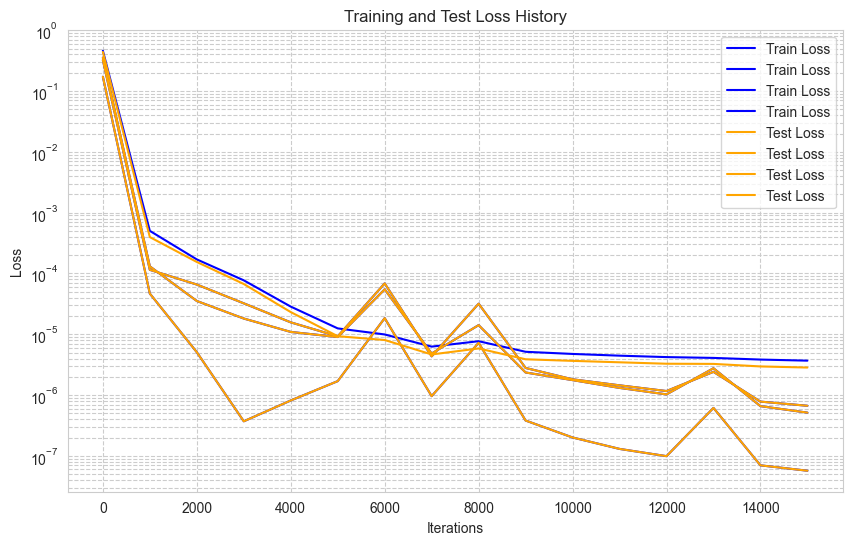

In [44]:
# Plot the loss history
plt.figure(figsize=(10, 6))
train_loss = np.array(losshistory.loss_train)
test_loss = np.array(losshistory.loss_test)
steps = losshistory.steps

plt.plot(steps, train_loss, label="Train Loss", color='blue')
plt.plot(steps, test_loss, label="Test Loss", color='orange')

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training and Test Loss History")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()



### Predicted Solution

To visualize the solution $u(x, t)$, we need to:
1.  Create a grid of points `(x, t)` covering the entire domain.
2.  Use the trained `model.predict()` function to get the predicted value of $u$ at each of these points.
3.  Reshape the flat prediction array back into a 2D grid.
4.  Use a pseudocolor plot (`pcolormesh`) to display the temperature distribution over space and time. The resulting plot should show the heat diffusing from the initial sinusoidal state, consistent with the physical behavior of the heat equation.


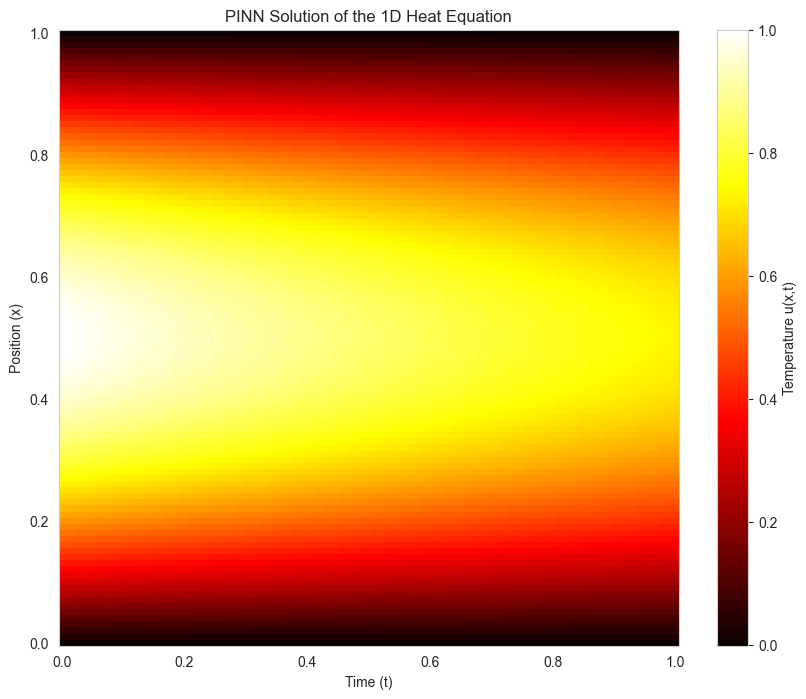

In [45]:
# Predict the solution for visualization
x_plot = np.linspace(0, 1, 101)
t_plot = np.linspace(0, 1, 101)
X, T = np.meshgrid(x_plot, t_plot)
X_flat = X.flatten()
T_flat = T.flatten()
xt_test = np.vstack((X_flat, T_flat)).T

u_pred = model.predict(xt_test)
U_pred = u_pred.reshape(X.shape)

# Plotting the predicted solution
plt.figure(figsize=(10, 8))
plt.pcolormesh(T, X, U_pred, shading='auto', cmap='hot')
plt.colorbar(label="Temperature u(x,t)")
plt.xlabel("Time (t)")
plt.ylabel("Position (x)")
plt.title("PINN Solution of the 1D Heat Equation")
plt.show()
